# MNIST 데이터셋을 Classification Model 로 구현해보기
- 풀고자 하는 문제는, 흑백 손글씨 이미지를 보고, 이 손글씨가 0 ~ 9 중 어떤 숫자인지를 맞추는 문제입니다.
- 즉, 흑백 이미지를 0 ~ 9, 총 10개의 숫자로 분류를 해야합니다.
- 그래서 MNIST 데이터셋을 input 으로 받아서 10 개의 숫자 중 1개로 분류해주는 Classification Model 을 만들어 보겠습니다.  

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 100

In [3]:
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(
    root="../data", train=True, transform=transform, download=True
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

test_set = torchvision.datasets.MNIST(
    root="../data", train=False, transform=transform, download=True
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False
)

In [4]:
def get_device() -> torch.device:
    """
    mps, cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """
    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = get_device()
device

device(type='mps')

## Cross Entropy Loss 함수
- Cross Entropy Loss (교차 엔트로피 손실)는 분류 문제에서 널리 사용되는 손실 함수
- 이 함수는 모델의 예측 확률 분포와 실제 레이블의 확률 분포 간의 차이를 측정

### 수식
$$L = -\sum_{i=1}^{C} y_i \log(p_i)$$
- $C$는 클래스의 수
- $y_i$는 실제 레이블 (원-핫 인코딩)
- $p_i$는 클래스 $i$에 대한 모델의 예측 확률

### MNIST 분류에서의 사용 이유
- 확률적 해석 
   - Cross Entropy Loss를 사용하면 모델의 출력을 확률로 해석할 수 있습니다.
   - MNIST에서 각 숫자(0-9)에 대한 예측 확률을 직접적으로 얻을 수 있습니다.

- 학습 효율성 
   - 오차가 클수록 더 큰 페널티를 부여합니다.
   - 이는 모델이 잘못된 예측에 대해 더 빠르게 학습하도록 유도합니다.

- 다중 클래스 적합성 
   - MNIST는 10개의 클래스(0-9)를 가진 다중 클래스 문제입니다.
   - Cross Entropy Loss는 다중 클래스 분류에 자연스럽게 적용됩니다.

- 미분 가능성 
   - 이 손실 함수는 연속적이고 미분 가능합니다.
   - 이는 역전파 알고리즘을 사용한 신경망 학습에 필수적입니다.


In [5]:
class SimpleMNISTClassificationModel(nn.Module):
    """
    MNIST dataset 과 같은 이미지를 구분하는 Model
    """

    def __init__(self, input_dimension, output_dimension):
        super(SimpleMNISTClassificationModel, self).__init__()
        hidden_dim = 1024
        self.layer1 = nn.Linear(input_dimension, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dimension)
        self.activation = nn.ReLU()

    def forward(self, x):
        # x.shape: (batch_size, 1, 28, 28)
        x = torch.flatten(x, start_dim=1)  # x.shape: (batch_size, 1 * 28 * 28)
        x = self.activation(self.layer1(x))  # x.shape: (batch_size, 1024)
        x = self.activation(self.layer2(x))  # x.shape: (batch_size, 1024)
        x = self.activation(self.layer3(x))  # x.shape: (batch_size, 10)
        return x

In [6]:
# input dimension 은 이미지의 크기, output dimension 은 0 ~ 9 까지의 분류
classification_model = SimpleMNISTClassificationModel(1 * 28 * 28, 10).to(device)

In [7]:
from torch.optim import SGD

optimizer = SGD(classification_model.parameters(), lr=LEARNING_RATE)

In [8]:
# '손실 함수'를 'criterion'이라고 부르는 것은 PyTorch 의 관행
# 단순히 '손실'을 넘어 '평가 기준'이라는 더 넓은 의미를 가짐
# 이는 모델의 성능을 평가하고 최적화하는 기준이 됨
criterion = nn.CrossEntropyLoss()

In [9]:
training_accuracies = []

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0

    total_images = 0
    total_correctness = 0
    for data in train_loader:
        classification_model.zero_grad()

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = classification_model(inputs)  # logits 이 출력됨.

        loss = criterion(
            outputs, labels
        )  # cross entropy 에는 나온 출력값(logits) 그대로 넣어준다.
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(
            outputs, dim=-1
        )  # 제일 점수가 높은 분류에 대한 인덱스만 뽑음 -> 예측한 분류 리스트가 됨

        total_images += labels.shape[0]  # 총 이미지 수(== 총 레이블 수)
        total_correctness += (
            (labels == predictions).sum().item()
        )  # 실제 레이블과 예측 레이블이 같은 것만 더 함 -> 몇 개를 맞추었는가

    accuracy = total_correctness / total_images
    print(f"Epoch {epoch + 1:3d} | Loss: {total_loss} | Accuracy: {accuracy}")

    training_accuracies.append(accuracy)

Epoch   1 | Loss: 540.2785341739655 | Accuracy: 0.13996666666666666
Epoch   2 | Loss: 538.000344991684 | Accuracy: 0.20775
Epoch   3 | Loss: 535.4515228271484 | Accuracy: 0.2765
Epoch   4 | Loss: 532.5991287231445 | Accuracy: 0.3437
Epoch   5 | Loss: 529.545934677124 | Accuracy: 0.406
Epoch   6 | Loss: 526.2808675765991 | Accuracy: 0.4542
Epoch   7 | Loss: 522.7319445610046 | Accuracy: 0.48115
Epoch   8 | Loss: 518.7962293624878 | Accuracy: 0.49806666666666666
Epoch   9 | Loss: 514.4300229549408 | Accuracy: 0.5071333333333333
Epoch  10 | Loss: 509.56984972953796 | Accuracy: 0.514
Epoch  11 | Loss: 504.14978218078613 | Accuracy: 0.5232833333333333
Epoch  12 | Loss: 498.09056067466736 | Accuracy: 0.5270333333333334
Epoch  13 | Loss: 491.33814454078674 | Accuracy: 0.5370166666666667
Epoch  14 | Loss: 484.0396716594696 | Accuracy: 0.5418666666666667
Epoch  15 | Loss: 476.0286206007004 | Accuracy: 0.5496833333333333
Epoch  16 | Loss: 467.37899947166443 | Accuracy: 0.5577
Epoch  17 | Loss: 4

In [10]:
test_accuracies = []

with torch.no_grad():
    classification_model.eval()

    for epoch in range(NUM_EPOCHS):
        total_images = 0
        total_correctness = 0

        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = classification_model(images)
            predictions = torch.argmax(outputs, dim=-1)

            total_images += labels.shape[0]
            total_correctness += (labels == predictions).sum().item()
        accuracy = total_correctness / total_images
        test_accuracies.append(accuracy)

In [11]:
len(training_accuracies), len(test_accuracies)

(100, 100)

In [12]:
from matplotlib import pyplot as plt
import numpy as np


def plot_acc(train_accuracies, test_accuracies, label1="train", label2="test"):
    x = np.arange(len(train_accuracies))

    plt.plot(x, train_accuracies, label=label1)
    plt.plot(x, test_accuracies, label=label2)
    plt.legend()
    plt.show()

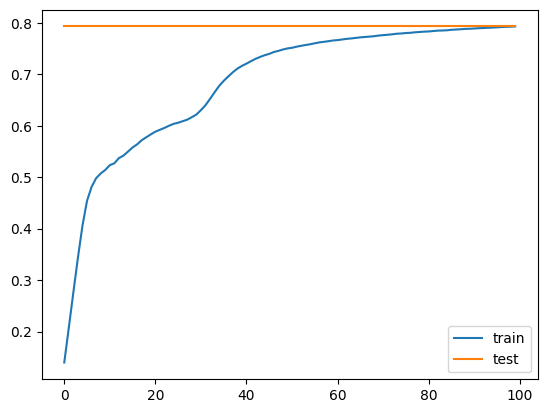

In [13]:
plot_acc(training_accuracies, test_accuracies)